# Studying minimum allowable distance between spiral tips
Tim Tyree<br>
4.18.2021

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from numba import njit
#load the libraries
from lib import *

from lib.my_initialization import *
from lib.controller.controller_LR import get_one_step_explicit_synchronous_splitting
from lib.model.LR_model import *
from lib.utils.utils_traj import *
from lib.routines.bdrates import *
from lib.measure.utils_measure_tips_cpu import *
from lib.utils.stack_txt_LR import *
from lib.viewer import *
import trackpy
from lib.utils import load_buffer

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# initialize a token case repeatably

In [2]:
# ic_fn=search_for_file()
ic_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-in/ic008.33.npz"
txt=load_buffer(ic_fn)
t=0

In [3]:
# get_one_step
dt, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,
    dt=0.01,
    width=200,
    height=200,
    ds=5.0,
    diffCoef=0.001,
    Cm=1.0)

In [4]:
inVc, outVc, inmhjdfx, outmhjdfx, dVcdt=unstack_txt(txt.copy())

In [5]:
tf=100.
while t<tf:
    one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
    t+=dt

In [6]:
#test timestep updates all channels
inVc0, outVc0, inmhjdfx0, outmhjdfx0, dVcdt0=unstack_txt(txt)
assert (np.max(np.abs(inVc0-inVc))>0)
assert (np.max(np.abs(outVc0-outVc))>0)
assert (np.max(np.abs(inmhjdfx0-inmhjdfx))>0)
assert (np.max(np.abs(outmhjdfx0-outmhjdfx))>0)
assert (np.max(np.abs(dVcdt0-dVcdt))>0)

In [7]:
width=200;height=200
compute_all_spiral_tips=get_compute_all_spiral_tips(width, height, mode='simp')

In [8]:
#compute all spiral tips present
V_threshold=-50.#mV
level1=V_threshold
# theta_threshold=0.
level2=0.
#take the first step
one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
t+=dt
img=inVc[...,0]
dimgdt=dVcdt[...,0]
dict_out=compute_all_spiral_tips(t,img,dimgdt,level1,level2)
dict_out_instantaneous=dict_out
print(np.max(inVc[...,0]))
dict_out_instantaneous

6.685565


{'t': 100.01000000001426,
 'n': 2,
 'x': [31.138359726046478, 92.77389184880282],
 'y': [94.457298609633, 46.08495673401471],
 'grad_ux': [48.259737476606624, -1.151004739451925],
 'grad_uy': [-14.571947944498362, 5.319836154079837],
 'grad_vx': [-1.1288285802531763, 10.04577590081355],
 'grad_vy': [1.6993420584559065, -17.202332047623162]}

2 tips are present at time t=100.


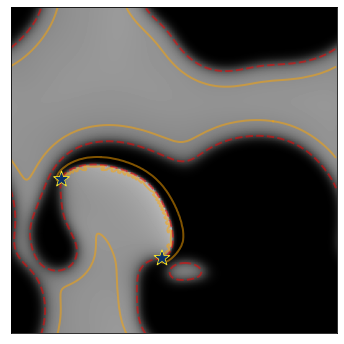

In [9]:
x_values=np.array(dict_out['x'])
y_values=np.array(dict_out['y'])
c_values=np.array(dict_out['x'])
print(f"{dict_out['n']} tips are present at time t={int(t)}.")
fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
                 area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,200,0,200])
plt.show(fig)

In [19]:
txt=stack_txt(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)

#save texture at this time t
save=True
if save:
#     txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    save_img_fn=os.path.basename(ic_fn).replace('.npz',f'_t_{t:.0f}.npz')
    save_img_folder=f"{nb_dir}/Data/test_data/"
    os.chdir(save_img_folder)
    #     img_out=txt#np.stack([img,dimgdt]).T
    np.savez_compressed(save_img_fn,[txt])

In [20]:
# os.path.abspath(save_img_fn)
txt_fn='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_data/ic008.33_t_100.npz'
#TODO: save txt as txt_save regularly at time t_save
#TODO: time step until a spiral tip death occurs

'/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_data/ic008.33_t_100.npz'

In [11]:
#DONE: detect all spiral tips present
#TODO: compute r=minimum distance between all spiral tips 
#TODO: record r given current time step
#TODO: repeat ^that death event using half the time step.  Is r different? ...If not, be sure before continuing.